In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
datacsv          = "C:\\Users\\julierozenberg\\Box Sync\\Mozambique\\GIS Data\\Routing_results\\Disruption_20170120\\"
list_csv         = os.listdir(datacsv)

In [3]:
baseline = pd.read_csv(datacsv+"dBaseline_02.csv")
baseline.index = baseline.O.astype(str)+'_'+baseline.D.astype(str)

In [4]:
countrydata = pd.read_csv("chuck august\Mozambique_OD_locations_20160527_01.csv")

In [5]:
countrydata.sample(2)

,INDEX_OD,INDEX_previous,OD_type,Name,LATITUDE,LONGITUDE,Road_processed,Has_no_road
98,99,13,population_cluster,NaN,-15.060874,40.318333,1,NaN
20,20,18,airport,Luabo,-18.400000,36.100000,1,NaN


In [6]:
baseline.sample(2)

,O,D,TOTAL_RUC,TOTAL_LENGTH,TOTAL_TRAVEL_TIME
17_37,17,37,59.450105,270.152397,2.602108
27_48,27,48,539.007805,2557.687930,24.757542


In [7]:
traffic_xls = pd.read_excel("Mozambique_OD_locations_wTraffic_20160727.xls","Traffic_OD_matrix")

In [8]:
OD_info = pd.read_excel("Mozambique_OD_locations_wTraffic_20160823.xls","Mozambique_OD_locations_2016052")

In [9]:
OD_info.columns

Index(['INDEX_OD', 'INDEX_previous', 'OD_type', 'Name', 'LATITUDE',
       'LONGITUDE', 'Road_processed', 'Province', 'District', 'Study_area'],
      dtype='object')

In [10]:
OD_info = OD_info.rename(columns={'INDEX_OD':'road_index'})

In [11]:
road_info = pd.read_csv("MOZ_roads_all_20160817_ln_02d_wStudyArea.csv")

In [12]:
road_info.sample(2)

,SUM_RUC_km_total,MIN_Avg_speed,MAX_Traffic_analysis,SUM_Length_km,SUM_Travel_time,Road_index,study_area
318,0.000826,37,78,0.232450,0.006282,319,1
646,35.135426,29,78,69.478793,2.395820,647,1


In [13]:
traffic_xls.columns.name="D"
traffic_xls = traffic_xls.rename(columns={'OD_Traffic':'O'})

In [14]:
traffic = traffic_xls.set_index("O").unstack()

In [15]:
traffic.name = "traffic"

In [16]:
traffic = traffic.reset_index()
traffic.index = traffic.O.astype(str)+'_'+traffic.D.astype(str)

In [17]:
vul = pd.read_excel("crit_vuln_risk_database.xlsx")

In [18]:
vul.columns

Index(['FID', 'Shape *', 'OBJECTID', 'Dissolve_0', 'SUM_RUC_km', 'MIN_Avg_sp',
       'MAX_Traffi', 'SUM_Length', 'SUM_Travel', 'Road_index', 'Shape_Leng',
       'Max_WaterD', 'road_ind_1', 'missingrou', 'num_aff_ro', 'ruc_diff',
       'time_diff', 'km_diff', 'ruc_diff_w', 'crit_ruc_diff_w', 'WD_fCU5',
       'WD_fCU50', 'WD_fCU100', 'WD_fCC5', 'WD_fCC50', 'Wd_fCC100', 'WD_fLU5',
       'WD_fLU50', 'WD_fLU100', 'vuln_WD_fCU5', 'vuln_WD_fCU50',
       'vuln_WD_fCU100', 'vuln_WD_fCC5', 'vuln_WD_fCC50', 'vuln_Wd_fCC100',
       'vuln_WD_fLU5', 'vuln_WD_fLU50', 'vuln_WD_fLU100', 'risk_WD_fCU5',
       'risk_WD_fCU50', 'risk_WD_fCU100', 'risk_WD_fCC5', 'risk_WD_fCC50',
       'risk_Wd_fCC100', 'risk_WD_fLU5', 'risk_WD_fLU50', 'risk_WD_fLU100',
       'WatD_fc20', 'Agriculture_route'],
      dtype='object')

In [19]:
vul = vul.rename(columns={'Road_index':'road_index'})

In [26]:
costs_all = pd.DataFrame(columns=["road_index","missingroutes","missinginstudyarea",\
                           "num_aff_routes","ruc_diff","ruc_diff_pc","time_diff","km_diff","ruc_diff_with_traffic"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "Mozambique" in file:
        continue
    if "Baseline" in file:
        continue
    scenar = pd.read_csv(datacsv+file)
    road   = (re.search('d(.*)_02.csv', file).group(1))
    #road = (re.search('d(.*)_(.*)_01_20160817_01.csv', file).group(2))
    scenar.index = scenar.O.astype(str)+'_'+scenar.D.astype(str)
    scenar['weights']=traffic.traffic

    missingroutes = len(baseline)-len(scenar)
    baseline_missing = baseline.ix[[i not in scenar.index for i in baseline.index],:]
    baseline_missing['OD_study_area'] = baseline_missing.O.replace(OD_info.set_index('road_index').Study_area)+\
                                        baseline_missing.D.replace(OD_info.set_index('road_index').Study_area)
    missinginstudyarea = sum(baseline_missing.OD_study_area>0)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.TOTAL_RUC/baseline_nm.TOTAL_RUC,3)!=1)&(baseline_nm.TOTAL_RUC>0)
    if sum(affected_routes)==0:
        costs_all.loc[len(costs_all),:] = [road,missingroutes,missinginstudyarea,sum(affected_routes),\
                                           0,0,0,0,0]
    else:
    
        subscenar = scenar.ix[affected_routes,:]

        av_ruc_baseline   = np.average(baseline_nm.ix[affected_routes,"TOTAL_RUC"])
        diff_ruc_baseline   = (subscenar.TOTAL_RUC-\
                               baseline_nm.ix[affected_routes,"TOTAL_RUC"])
        diff_time_baseline   = (subscenar.TOTAL_TRAVEL_TIME-\
                               baseline_nm.ix[affected_routes,"TOTAL_TRAVEL_TIME"])
        diff_km_baseline = (subscenar.TOTAL_LENGTH-baseline_nm.ix[affected_routes,"TOTAL_LENGTH"])
        diff_tot_baseline   = (traffic.traffic*diff_ruc_baseline)

        ruc_diff  = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
        time_diff = np.sum(diff_time_baseline*subscenar.weights)/subscenar.weights.sum()
        km_diff   = np.sum(diff_km_baseline*subscenar.weights)/subscenar.weights.sum()
        cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()
        
        #ruc_diff  = np.sum(diff_ruc_baseline)
        #time_diff = np.sum(diff_time_baseline)
        #km_diff   = np.sum(diff_km_baseline)
        
        #ruc_diff  = np.average(diff_ruc_baseline)
        ruc_diff_pc  = ruc_diff/np.sum(baseline_nm.ix[affected_routes,"TOTAL_RUC"])
        #time_diff = np.average(diff_time_baseline)
        #km_diff   = np.average(diff_km_baseline)
        #cost_with_traffic  = np.sum(diff_tot_baseline)

        costs_all.loc[len(costs_all),:] = [road,missingroutes,missinginstudyarea,sum(affected_routes),\
                                           ruc_diff,ruc_diff_pc,time_diff,km_diff,cost_with_traffic]

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
costs_all.to_csv("results_0117_with_weight_sum.csv")

In [21]:
costs_all = pd.read_csv("results_0916_no_weight_average.csv")

In [22]:
costs_all['study_area'] = costs_all.road_index.astype(float).replace(road_info.set_index('Road_index').study_area)

In [23]:
costs_all[["missingroutes","num_aff_routes","ruc_diff","time_diff","km_diff","ruc_diff_with_traffic"]].astype(float).describe()

,missingroutes,num_aff_routes,ruc_diff,time_diff,km_diff,ruc_diff_with_traffic
count,801.000000,801.000000,801.000000,801.000000,801.000000,800.000000
mean,-965.117353,689.548065,12.352718,0.815823,32.861448,533877.310154
std,113.736235,1499.679660,19.720950,1.617728,62.253761,1870797.345448
min,-1001.000000,0.000000,0.000000,-2.747106,-140.004385,0.000000
25%,-1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1001.000000,32.000000,2.285186,0.006525,0.791474,83.224988
75%,-1001.000000,539.000000,16.999081,1.071360,46.214756,22710.459877
max,15.000000,7322.000000,144.460828,11.143128,417.001255,20413216.827031


In [24]:
def plot_histo(y,thecolor='blue',thelabel=''):    
    hist, bin_edges = np.histogram(y,bins=100,density=True)
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    if center.min()>0:
        xs = np.linspace(center.min()*0.85,center.max()*1.1,300)
    else:
        xs = np.linspace(center.min(),center.max(),300)
    #plt.bar(center, hist, align='center', width=width,alpha=0.05,color=thecolor)
    density = gaussian_kde(y)
    density._compute_covariance()
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=thelabel)

In [25]:
from pandas.tools.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E41A208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000DB8DF98>]], dtype=object)

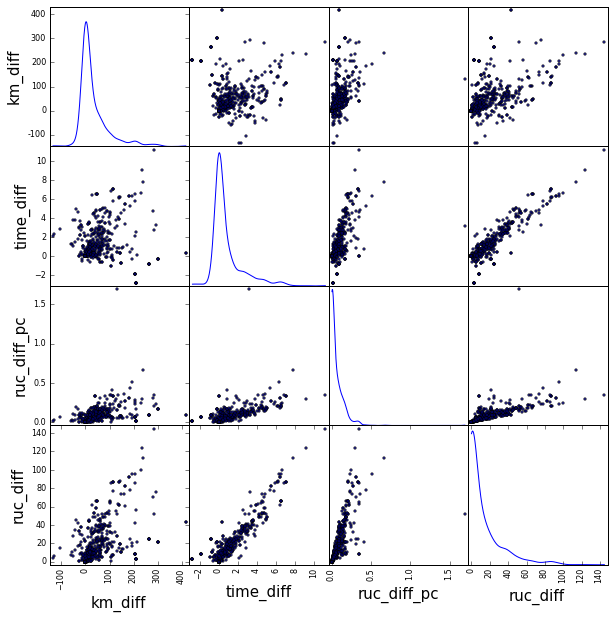

In [44]:
scatter_matrix(costs_all[['km_diff','time_diff','ruc_diff_pc','ruc_diff']].astype(float), alpha=0.8, diagonal='kde',figsize=(10,10))

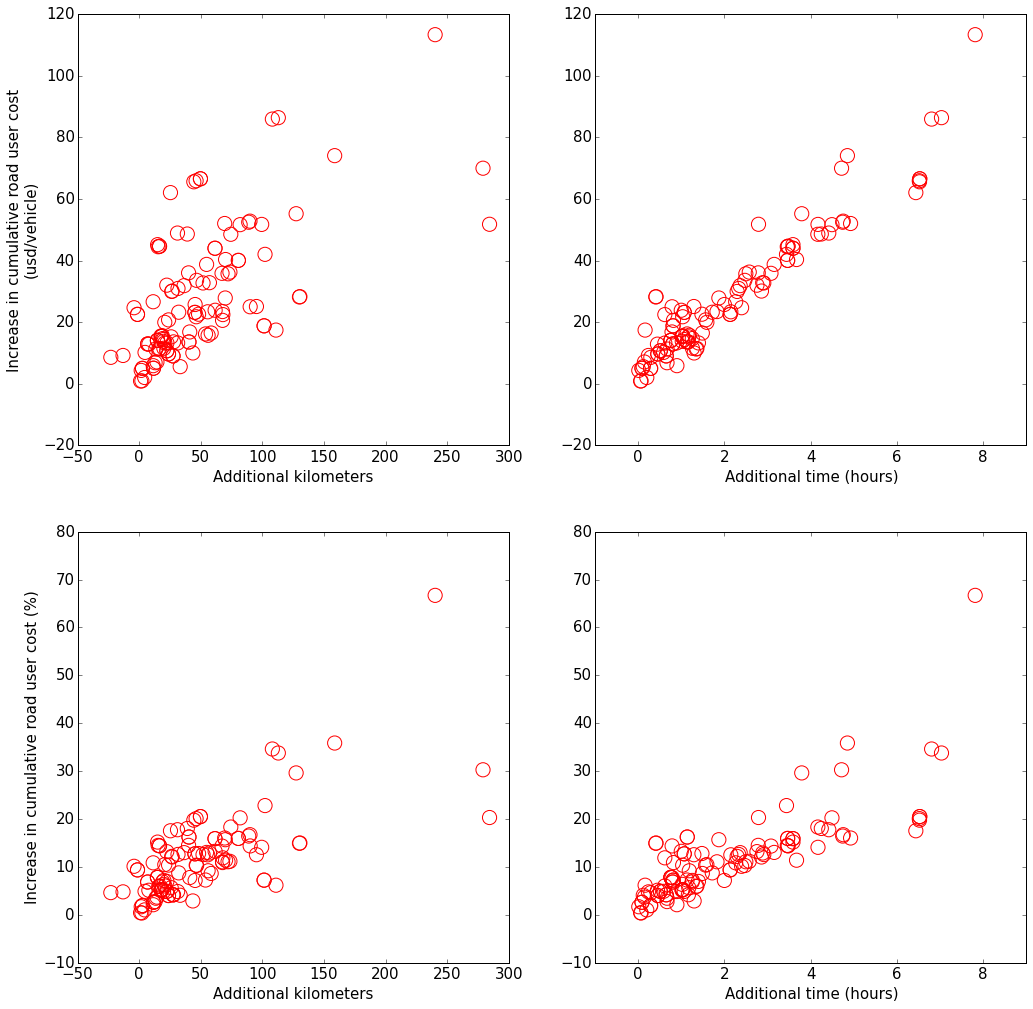

In [36]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(17,17))

select = (costs_all.study_area==1)&(costs_all.ix[:,'ruc_diff_with_traffic']>10000)

plt.subplot(221)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), costs_all.ix[select,'ruc_diff'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='red')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost\n(usd/vehicle)")

plt.subplot(222)
plt.scatter(costs_all.ix[select,'time_diff'].astype(float), costs_all.ix[select,'ruc_diff'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='red')
plt.xlabel("Additional time (hours)")

plt.subplot(223)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), 100*(costs_all.ix[select,'ruc_diff_pc']).astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='red')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost (%)")

plt.subplot(224)
plt.scatter(costs_all.ix[select,'time_diff'].astype(float), 100*(costs_all.ix[select,'ruc_diff_pc']).astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='red')
plt.xlabel("Additional time (hours)")

#plt.subplot(133)
#plt.scatter(costs_all.ix[select,'ruc_diff_with_traffic'].astype(float), costs_all.ix[select,'ruc_diff'].astype(float),\
           #s=200, alpha=1,facecolors='none',edgecolors='red')
#plt.xlabel("Increase in total cost (usd)")

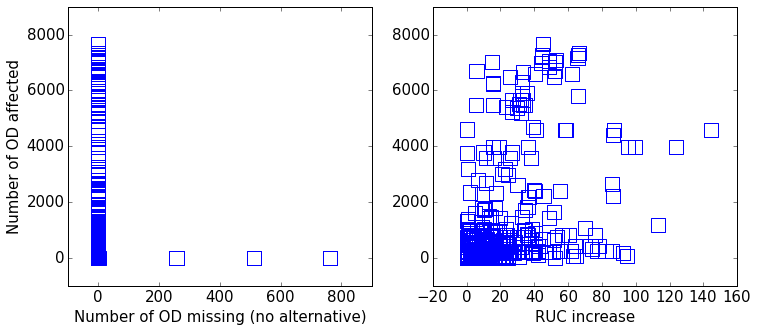

In [26]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(costs_all.missingroutes.astype(float), costs_all.num_aff_routes.astype(float),\
           s=200, alpha=1, marker='s',facecolors='none',edgecolors='blue')
plt.xlabel("Number of OD missing (no alternative)")
plt.ylabel("Number of OD affected")

plt.subplot(122)
plt.scatter(costs_all.ruc_diff.astype(float),costs_all.num_aff_routes.astype(float),\
           s=200, alpha=1, marker='s',facecolors='none',edgecolors='blue')
plt.xlabel("RUC increase")


In [27]:
costs_all.ix[(costs_all.missinginstudyarea.astype(float)>0)&(costs_all.study_area>0),["road_index","missinginstudyarea","study_area"]].drop_duplicates().to_csv("disruption_leads_to_missing_OD.csv",index=False)

In [28]:
costs_all.ix[costs_all.num_aff_routes>0,:];

In [25]:
costs_all.road_index = costs_all.road_index.astype(int)

In [26]:
df = costs_all.merge(vul[['WD_fCU5','WD_fCU50', 'WatD_fc20', 'WD_fCU100', 'WD_fCC5', 'WD_fCC50', 'Wd_fCC100',\
                    'WD_fLU5','WD_fLU50', 'WD_fLU100','road_index','Agriculture_route']],on='road_index')

In [27]:
from itertools import cycle, islice
from matplotlib.ticker import FuncFormatter as funfor

In [28]:
def y_thousands_sep(ax=None):
    if ax is None:
        ax=plt.gca()
    ax.get_yaxis().set_major_formatter(funfor(lambda x, p: format(int(x), ',')))
    plt.tight_layout()

In [29]:
def savefig(path, **kwargs):
    #Saves in both png and pdf
    
    plt.tight_layout()
    
    path = path.replace(".png","")
    path = path.replace(".pdf","")

    plt.savefig(path+".png", )
    plt.savefig(path+".pdf", )

In [30]:
df['Agriculture_route'].sample(3)

756    0
451    0
480    0
Name: Agriculture_route, dtype: int64

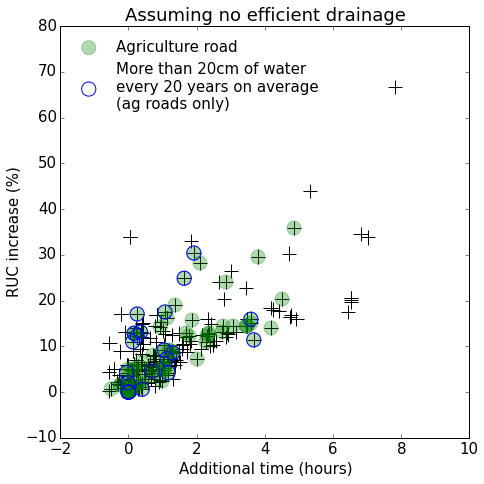

In [45]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))

select = df.study_area==1

flooded = (df.WatD_fc20>0.2)&(df.WD_fCU5!=999)

ag = df['Agriculture_route']>0

bridge = df.WD_fCU5==999

x = df.time_diff.astype(float)
y = 100*df.ruc_diff_pc.astype(float)

plt.subplot(111)
plt.scatter(x[select], y[select],s=200,marker='+', alpha=1,facecolors='none',edgecolors='black')

plt.scatter(x[select&ag], y[select&ag],s=200, alpha=0.3,facecolors='green',edgecolors='green',\
            label="Agriculture road")
plt.scatter(x[select&flooded&ag], y[select&flooded&ag],s=200, alpha=1,facecolors='none',edgecolors='blue',\
            label="More than 20cm of water\nevery 20 years on average\n(ag roads only)")

plt.legend(frameon=False,loc=2,scatterpoints=1,prop=font)
#y_thousands_sep()

plt.xlabel("Additional time (hours)")
plt.ylabel("RUC increase (%)")

plt.title("Assuming no efficient drainage")

savefig("floods_50_ag_pc.png")

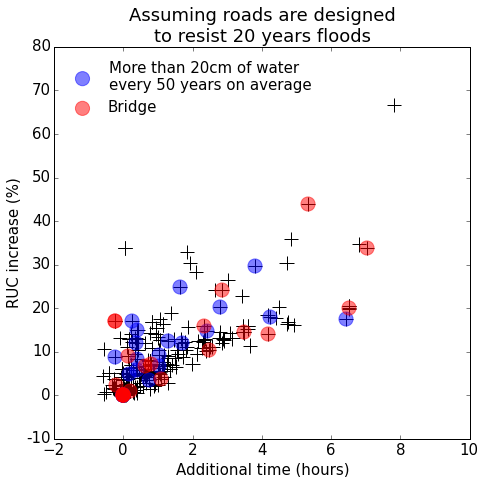

In [46]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))

select = df.study_area==1

flooded = (df.WD_fCU50-df.WatD_fc20>0.2)&(df.WD_fCU5!=999)

bridge = df.WD_fCU5==999

x = df.time_diff.astype(float)
y = 100*df.ruc_diff_pc.astype(float)

plt.subplot(111)
plt.scatter(x[select], y[select],s=200,marker='+', alpha=1,facecolors='none',edgecolors='black')

plt.scatter(x[select&flooded], y[select&flooded],s=200, alpha=0.5,facecolors='blue',edgecolors='blue',\
            label="More than 20cm of water\nevery 50 years on average")
plt.scatter(x[select&bridge], y[select&bridge],s=200, alpha=0.5,facecolors='red',edgecolors='red',\
            label="Bridge")

plt.legend(frameon=False,loc=2,scatterpoints=1,prop=font)
y_thousands_sep()

plt.xlabel("Additional time (hours)")
plt.ylabel("RUC increase (%)")

plt.title("Assuming roads are designed\nto resist 20 years floods")

savefig("floods_50_protection_pc.png")

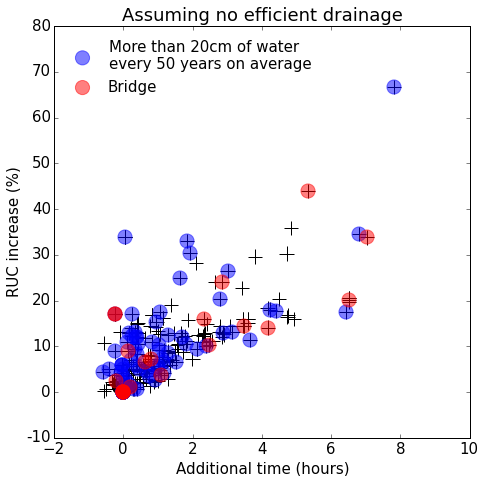

In [48]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))

select = df.study_area==1

flooded = (df.WD_fCU50>0.2)&(df.WD_fCU5!=999)

bridge = df.WD_fCU5==999

x = df.time_diff.astype(float)
y = 100*df.ruc_diff_pc.astype(float)

plt.subplot(111)
plt.scatter(x[select], y[select],s=200,marker='+', alpha=1,facecolors='none',edgecolors='black')

plt.scatter(x[select&flooded], y[select&flooded],s=200, alpha=0.5,facecolors='blue',edgecolors='blue',\
            label="More than 20cm of water\nevery 50 years on average")
plt.scatter(x[select&bridge], y[select&bridge],s=200, alpha=0.5,facecolors='red',edgecolors='red',\
            label="Bridge")

plt.legend(frameon=False,loc=2,scatterpoints=1,prop=font)
y_thousands_sep()

plt.xlabel("Additional time (hours)")
plt.ylabel("RUC increase (%)")

plt.title("Assuming no efficient drainage")

savefig("floods_50_pc.png")

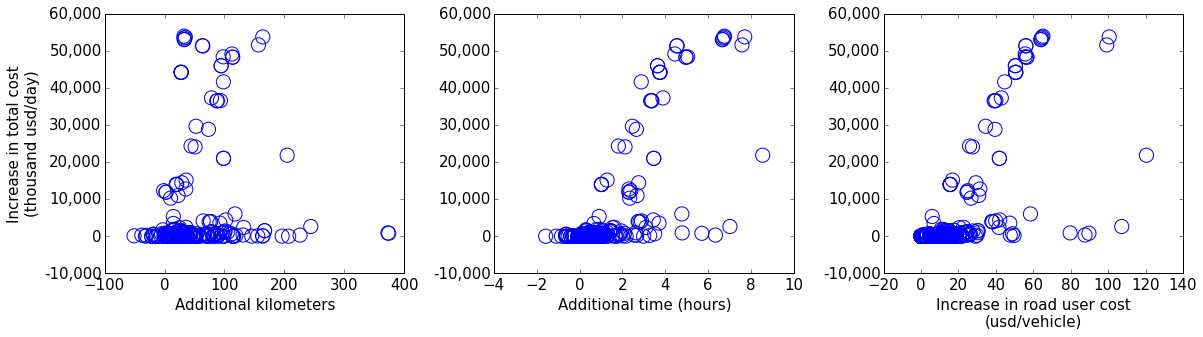

In [139]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(17,5))

select = costs_all.study_area==1

plt.subplot(131)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), costs_all.ix[select,'ruc_diff_with_traffic'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in total cost\n(thousand usd/day)")
y_thousands_sep()

plt.subplot(132)
plt.scatter(costs_all.ix[select,'time_diff'].astype(float), costs_all.ix[select,'ruc_diff_with_traffic'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional time (hours)")
y_thousands_sep()

plt.subplot(133)
plt.scatter(costs_all.ix[select,'ruc_diff'].astype(float), costs_all.ix[select,'ruc_diff_with_traffic'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Increase in road user cost\n(usd/vehicle)")

y_thousands_sep()
savefig("criticality.png")

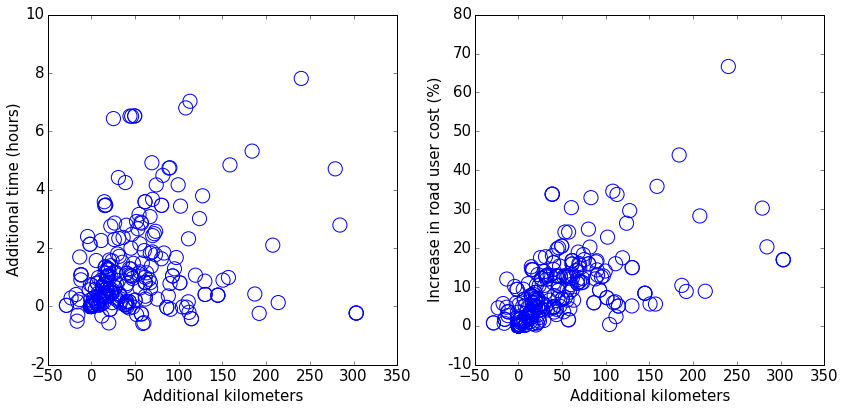

In [50]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(12,6))

select = costs_all.study_area==1

plt.subplot(121)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), costs_all.ix[select,'time_diff'],\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional kilometers")
plt.ylabel("Additional time (hours)")
y_thousands_sep()

plt.subplot(122)
plt.scatter(costs_all.ix[select,'km_diff'].astype(float), 100*costs_all.ix[select,'ruc_diff_pc'].astype(float),\
           s=200, alpha=1,facecolors='none',edgecolors='blue')
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in road user cost (%)")
y_thousands_sep()

savefig("criticality2_pc.png")